In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import pandas as pd

# Funções de Plot

In [2]:
def plotdataset(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

In [3]:
def plothiperplano(X,y,vetor,intercept=0):
    X0min = min(X[:,0])
    X0max = max(X[:,0])
    xs = np.linspace(X0min,X0max,num = 2)
    ys = (-vetor[0]/vetor[1]) * xs-intercept/vetor[1]
    plt.plot(xs,ys)

# Funções de custo

In [4]:
def sign(a):
  return (a >=0)*2-1

In [5]:
class custo(ABC):
  @abstractstaticmethod
  def custo(y,ypred):
    pass
  @abstractstaticmethod
  def gradiente(y,ypred):
    pass

In [6]:
class WidrowHoff(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum((y-ypred)**2)
  @staticmethod
  def gradiente(y,ypred):
    return y-ypred

In [7]:
class SmoothedSurrogate(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),-y*ypred))

  @staticmethod
  def gradiente(y,ypred):
    return y-sign(ypred)

In [8]:
class Hingeloss(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.maximum(np.zeros(y.shape),1-y*ypred))
  
  @staticmethod
  def gradiente(y,ypred):
    errormarginais = (y*ypred) < 1
    ymarginais = np.copy(y)
    ymarginais[~errormarginais] = 0
    return ymarginais

In [9]:
class loglikehood(custo):
  @staticmethod
  def custo(y,ypred):
    return np.sum(np.log(1+np.exp(-y*ypred)))
  @staticmethod
  def gradiente(y,ypred):
    return y-(expit(ypred)*2-1)

# Definições do Perceptron

In [15]:
class Perceptron(ClassifierMixin,BaseEstimator):
  def __init__(self,training_algorithm):
    self.w = None
    self.activation = sign
    self.training_algorithm = training_algorithm

  @staticmethod
  def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

  def fit(self,X,y):
    yhot = self.encode_labels(y)
    Xb = Perceptron.includebias(X)
    self.w = self.training_algorithm.getW(Xb,yhot)
    
  def __pre_activation(self,X):
      X = Perceptron.includebias(X)
      return X @ self.w

  def predict(self,X,y=None):
      a = self.__pre_activation(X)
      if self.w.shape[1] == 1:
        idx = np.array(a > 0,dtype=int).reshape((-1,))
      else:
        idx = np.argmax(a,axis=1)
      ypred = np.array([self.labels[i] for i in idx])
      return ypred

  def encode_labels(self,y):
    self.labels = list(set(y))
    return label_binarize(y,classes=self.labels)*2-1

In [16]:
class trainingalgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass

In [17]:
class DescidaGradiente(trainingalgorithm):
  def __init__(self,max_iter=2000,learning_rate=0.01,regularization=0,cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost
    self.custobatch = []

  def getW(self,X,y):
    w = np.random.uniform(-1,1,size=(X.shape[1],y.shape[1]))
    #forma batch de encontrar os erros
    for j in range(self.max_iter):
      ypred = X @ w
      custo = self.cost.custo(y,ypred)
      self.custobatch.append(custo)
      if custo == 0:
        break
      w *= 1-self.learning_rate*self.regularization
      w += (X.T @ self.cost.gradiente(y,ypred)) * self.learning_rate 

    return w

In [18]:
def predicaoRN(lr):
  custos = [loglikehood(),Hingeloss()]
  for i in custos:
    print(type(i).__name__)
    descida = DescidaGradiente(cost=i,learning_rate=lr)
    perceptron = Perceptron(descida)
    perceptron.fit(Xtr,ytr)
    ypred = perceptron.predict(Xtr)
    print(sum(ypred == ytr)/len(ytr))
    plotdataset(Xtr,ytr)
    print(descida.custobatch)
    for i in range(perceptron.w.shape[1]):
      plothiperplano(Xtr,ytr,perceptron.w[1:,i],perceptron.w[0,i])
    plt.show()
    plt.plot(descida.custobatch)
    plt.show()

# Predição Multiclasse dataset Iris

In [19]:
from sklearn import datasets
iris = datasets.load_iris()
Xm = iris.data
ym = iris.target
Xtr,Xte,ytr,yte = train_test_split(Xm,ym,test_size=0.90)

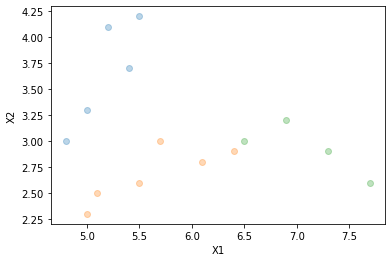

In [20]:
plotdataset(Xtr,ytr)

loglikehood
0.9333333333333333
[66.14991339422353, 95.85504814218731, 35.75613468892301, 55.14329546035762, 63.701671819046474, 64.29033250855828, 29.05054310508316, 52.711269482680116, 38.587534077982596, 54.64743025191688, 25.14239110669446, 39.25971448276221, 36.92433442704229, 50.616063790050255, 25.359020662094846, 37.270039923654565, 35.88676355477218, 47.85444529659171, 25.21758041895476, 36.11790250201897, 34.486683661224426, 45.50164189613319, 24.981667810755066, 35.41147078705483, 32.86347663787959, 43.42347516370304, 24.616801029426306, 34.86280205309714, 31.16879801097867, 41.55730464836093, 24.09661102402002, 34.32722423424523, 29.45890809018341, 39.84469957730856, 23.410292575466922, 33.73105727991966, 27.746739292485014, 38.236623583471065, 22.559179217735693, 33.042848328105315, 26.03535924733965, 36.70446592004886, 21.56806241947349, 32.275345896573704, 24.353565043983416, 35.269227669872855, 20.51980592357543, 31.51567051922408, 22.81339291489789, 34.040574741057284, 

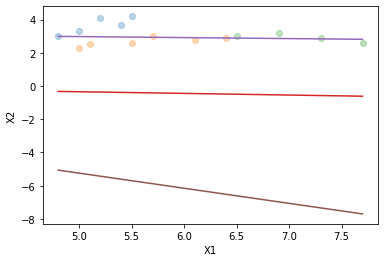

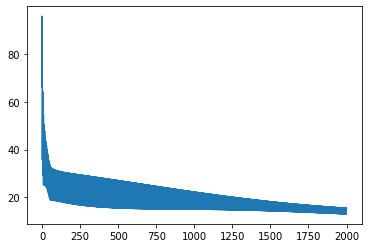

Hingeloss
0.8
[107.55126059399987, 57.186705985907246, 42.18650598590724, 39.715382129206844, 57.99445275982614, 54.64673274663703, 27.421035341666308, 38.31877832429205, 46.47033274663702, 23.270908585664003, 30.14561785147186, 44.934642583805854, 38.339452319281, 26.475356705405595, 27.174044791791943, 35.538167321648736, 35.88337850200595, 24.73935836651955, 22.83725926906177, 39.3148776253948, 31.996292979275783, 25.004163655186375, 24.736459269061765, 34.2676776253948, 33.922992979275776, 24.52589759209457, 19.014226214193208, 26.500797592094578, 16.607488846236173, 24.201896834315544, 21.649759269061754, 37.138277625394814, 30.891292979275768, 24.173086774915856, 17.77645513602214, 25.840886774915855, 15.494634791330936, 21.30156867026564, 20.979359269061742, 38.34077762539482, 30.01625926906174, 25.9529636551864, 19.072838924370544, 30.697277625394822, 34.875859269061756, 22.78199759209458, 17.96202621419319, 24.75689759209458, 15.488701081116925, 23.64469683431555, 17.715705214

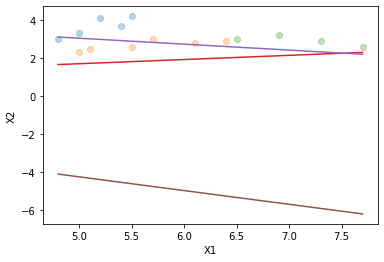

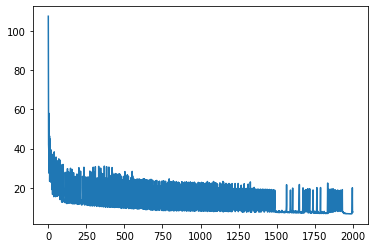

In [21]:
predicaoRN(0.01)

# Predição dataset binário

In [67]:
def criadatasetbinary(n=200):
  X = np.random.uniform(size=(n,2))
  y = np.array(X[:,0] > X[:,1],dtype=int)* 2-1
  return X,y

In [68]:
Xm,ym = criadatasetbinary(n=1000)
Xtr,Xte,ytr,yte = train_test_split(Xm,ym,test_size=0.90)

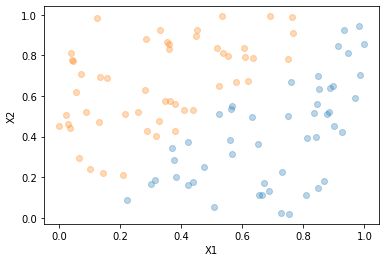

In [69]:
plotdataset(Xtr,ytr)

loglikehood
0.99
[66.22076275656451, 62.64659770187571, 60.587583905722795, 58.7386064715918, 57.01917856809703, 55.4155320330039, 53.91790104361761, 52.51743985209069, 51.206045378536054, 49.97631327789801, 48.82149436353926, 47.73544780973327, 46.71259323036191, 45.74786334170324, 44.83665837391482, 43.97480297096648, 43.158506002426456, 42.384323481538345, 41.64912462339127, 40.95006096849706, 40.28453842749272, 39.65019206144979, 39.044863391242, 38.466580022408905, 37.913537374363, 37.3840823112531, 36.87669848391245, 36.389993206381085, 35.92268570533627, 35.47359659560446, 35.04163844926465, 34.625807339376394, 34.225175251912766, 33.838883270972474, 33.46613545277964, 33.10619331338285, 32.75837086339492, 32.42203013063783, 32.09657711825278, 31.781458151777095, 31.476156573954235, 31.180189750702247, 30.893106355783523, 30.61448390535796, 30.343926516815216, 30.08106286912057, 29.82554434441634, 29.577043332836467, 29.33525168445042, 29.099879293984863, 28.870652805504587, 28.

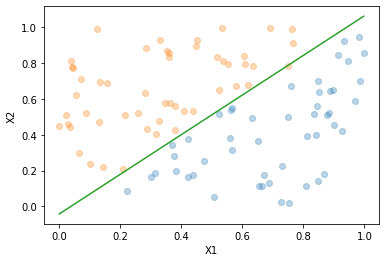

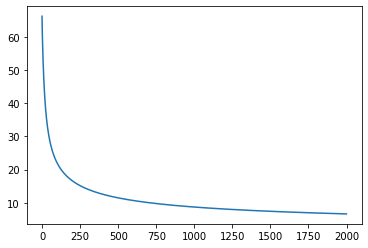

Hingeloss
0.99
[110.75170501141875, 105.39525572523603, 100.32354302317272, 95.28836050913209, 90.25317799509145, 85.22146475643846, 80.22434070933939, 75.2611126437753, 70.37475811096729, 65.67362204423094, 61.08286466014319, 56.57585477932071, 52.41200796319895, 49.2588826958863, 46.43183061237691, 44.115812678060685, 42.14654449108578, 40.69173162824304, 39.53880349759969, 38.40260343164207, 37.37498615361379, 36.55516213155901, 35.78823965466326, 35.12518630532784, 34.47720405227211, 33.869810211533824, 33.262416370795535, 32.68013914795451, 32.160287862130765, 31.653291263582737, 31.21366217522743, 30.81055350459296, 30.497874144379885, 30.190492376253033, 29.874646270965016, 29.584195640027353, 29.293745009089694, 29.003294378152038, 28.71284374721438, 28.42239311627672, 28.131942485339057, 27.841491854401394, 27.551041223463738, 27.270989776365685, 26.98936421484995, 26.70773865333421, 26.440288669349215, 26.18044303891267, 25.923220242738108, 25.668120191236973, 25.421018799438

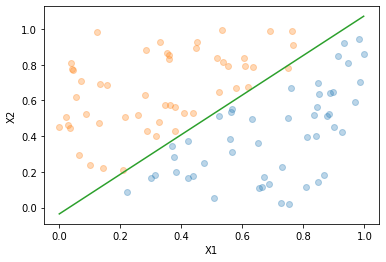

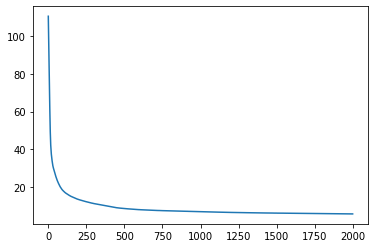

In [70]:
predicaoRN(0.01)